## Set Up

In [1]:
# !/usr/env python3

'''
Output:
video captioning model itself and produce loss curve

Usage:
main document to train the video captioning model
'''

# set up
from __future__ import print_function
import tensorflow as tf
import pickle
import os
import numpy as np
import logging
import matplotlib.pyplot as plt
from util import *
from model.video_caption import sequence_2_sequence_LSTM
from load_caption_feature import *
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import gc

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## Process and save data  
Load caption Xtrain, Xtest, ytrain, ytest, video_train, video_test and save them.  
Here in details, see **load_caption_feature.py**. Only need to run once, codes are going to save the data file. 

In [ ]:
# load and save training data
num_frames = 15
size = (224, 224, 3)

# more balanced data
idx_path = os.getcwd() + '/datasets/x_train_ind_above400.npy'
Xtrain_idx = np.load(idx_path)
labels = np.load(os.getcwd() + '/datasets/y_train_mapped_above400.npy')

# if all videos then 
num_videos = len(Xtrain_idx)

tic = datetime.now()
# for clearing memory convenience
model = vgg_16_pretrained()
Xtr, ytr = load_features(model, num_videos, num_frames, Xtrain_idx, labels, size = (224, 224, 3), train_test_flag='train')

In [5]:
# clear memory
del Xtr
del ytr
model = None
gc.collect()

0

In [3]:
# load and save test data
num_frames_test = 15
size = (224, 224, 3)

# more balanced data
idx_path = os.getcwd() + '/datasets/x_test_ind_above400.npy'
Xtest_idx = np.load(idx_path)
ytest = np.load(os.getcwd() + '/datasets/y_test_mapped_above400.npy')

# if all videos then 
num_videos_test = len(Xtest_idx)

model = vgg_16_pretrained()
Xte, yte = load_features(model, num_videos_test, num_frames_test, Xtest_idx, ytest, size = (224, 224, 3), train_test_flag='test')

In [10]:
# clean memory
del Xte
del yte
model = None
gc.collect()

0

In [11]:
# save input frames train and test
curr = os.getcwd() + '/datasets'
def save_frames(X, vid_ls, mode = 'train'):
    X = X.reshape((-1, 15, 4096))
    assert X.shape[0] == len(vid_ls)
    input_frames = {}
    for i in range(X.shape[0]):
        vid = vid_ls[i]
        input_frames[vid] = Xtr[i]
    pickle.dump(input_frames, open(curr + '/input_frames_' + mode + '.pickle', 'wb'))

vid_train = np.load(curr + '/videoIdtrain_allCap_15frames.npy')
Xtr = np.load(curr + '/Xtrain_allCap_15frames.npy')
Xte = np.load(curr + '/Xtest_allCap_15frames.npy')
vid_test = np.load(curr + '/videoIdtest_allCap_15frames.npy')
save_frames(Xtr, vid_train, mode = 'train')
save_frames(Xte, vid_test, mode = 'test')

## Model setup and train

### Model Configuration and Parameters 
Parameters:  

* model_name: the name of model, here we refer sequence to sequence model from [1](https://arxiv.org/abs/1505.00487);  
* state_size: lstm encoder and encoder state dimension  
* learning_rate: learning rate  
* input_size: vector size input to lstm, here we use pretrained VGG16 output 4096 dimension  
* batch_size: batch size  
* max_sentence_length: fixed length for captions, default is 20 
* word_vector_size: depends on vocabulary chosen, here is 50, but can be changed 
* voc_size: depends on vocabulary created, if self-created vocabulary, it is 6169, if glove
* n_epoches: the number of epoches to run  
* num_frames: frame number  
* hidden_size: lstm encoder and encoder hidden dimension 

**Reference**  
[1] Venugopalan, S., Rohrbach, M., Donahue, J., Mooney, R., Darrell, T., & Saenko, K. (2015). Sequence to sequence-video to text. In Proceedings of the IEEE International Conference on Computer Vision (pp. 4534-4542).  

In [2]:
# define parameters
lr = 1e-6
hidden_size = 100
state_size = 100
batch_size = 64
voc_size = 6169
epoch = 50
word_dim = 50

logging.basicConfig(level=logging.INFO)
#=======Change These===============================
tf.app.flags.DEFINE_string("model_name", "sequence2sequence", "name of the model")
tf.app.flags.DEFINE_integer("state_size", state_size, "Size of each model layer.")
tf.app.flags.DEFINE_float("learning_rate", lr, "Base Learning rate.")
#==================================================

tf.app.flags.DEFINE_float("input_size", 4096, "input size for each frame")
tf.app.flags.DEFINE_integer("batch_size", batch_size, "how many videos put per run")
tf.app.flags.DEFINE_integer("max_sentence_length", 20, "maximum captioning sentence length")
tf.app.flags.DEFINE_integer("word_vector_size", word_dim, "word embedding dimension default is 25 for twitter glove")
tf.app.flags.DEFINE_integer("voc_size", voc_size, "vocabulary size")
tf.app.flags.DEFINE_integer("n_epochs", epoch, "number of epoch to run")
tf.app.flags.DEFINE_integer("num_frames", 15, "number of frames per video")
tf.app.flags.DEFINE_integer("hidden_size", hidden_size, "output size of LSTM encoder and decoder")
FLAGS = tf.app.flags.FLAGS        

### Load Training Data

In [3]:
def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

curPath = os.getcwd()
dataPath = curPath + "/datasets/"

# pick first 100 for debugging purpose
# load data
sample_size = 500
wvector_dim = 50
is_training = True
input_frames_train, captions_train, \
        word_dict, word2Index, index2Word = load_caption_data(sample_size, dataPath, train = is_training)
word_embedding = word_embedding_array(word_dict, wvector_dim, word2Index) 
print('Finish loading training data!')

Finish loading training data!


### Build Model Graph  
In details, see **model/video_caption.py**.   
We refer to sequence to sequence model to build two LSTM layers. One is encoder, and the other is decoder. The cell number of decoder depends on the maximum caption length we set. Here we choose 20 here by exploring the distribution of captions. In order to make encoder have same length of outputs, we add pad cells to encoder. Encoder accept 15 frames VGG16 outputs so that it has 15 cells. 

In [ ]:
# build model graph
tf.reset_default_graph()
model = sequence_2_sequence_LSTM(word_embedding, FLAGS)
model.train_embedding = True
model.build()

start building model ...
total number of parameter 2093900


In [5]:
# check variables
for v in tf.trainable_variables():
    print(v)

<tf.Variable 'embeddings/embeddings:0' shape=(6169, 50) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/encoder/basic_lstm_cell/weights:0' shape=(4596, 2000) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/encoder/basic_lstm_cell/biases:0' shape=(2000,) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/decoder/basic_lstm_cell/weights:0' shape=(1050, 2000) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/decoder/basic_lstm_cell/biases:0' shape=(2000,) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/decoder/hidden_to_scores/kernel:0' shape=(500, 50) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/decoder/hidden_to_scores/bias:0' shape=(50,) dtype=float32_ref>


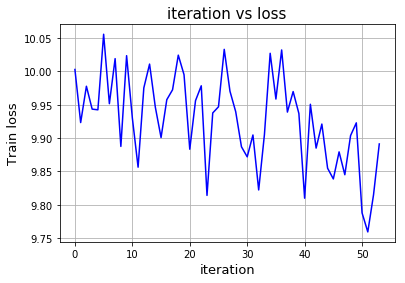

 1/50 [..............................] - ETA: 1525s - train loss: 9.9273 - dev loss: 10.3121 
Validation loss improved, Save Model!


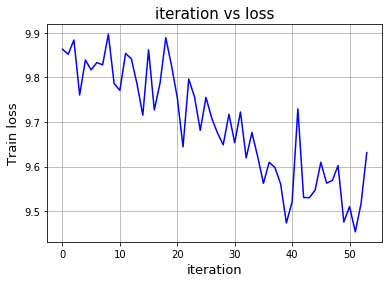

 2/50 [>.............................] - ETA: 1399s - train loss: 9.6935 - dev loss: 10.1089

In [ ]:
# run training mode
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    out = model.train(sess, (input_frames_train, captions_train), verbose = True)

In [7]:
# unpack
val_loss, tr_loss, tr_pred, val_pred, train_vid, val_vid = out

### Plot Learning Curves

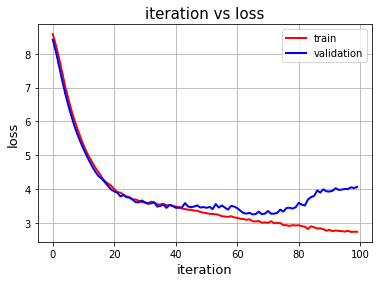

In [8]:
# plot learning curve
plt.plot(range(len(tr_loss)), tr_loss, 'r-', linewidth = 2, label = 'train')
plt.plot(range(len(val_loss)), val_loss, 'b-', linewidth = 2, label = 'validation')
plt.grid()
plt.xlabel('iteration', fontsize = 13)
plt.ylabel('loss', fontsize = 13)
plt.title('iteration vs loss', fontsize = 15)
plt.legend()
plt.savefig(os.getcwd() + '/output/caption_learning_curve.png')

### Check batch captions

In [11]:
# check captions
batch_size = 24
# sample = tr_pred[idx] # training
# # sample = val_pred[idx] # validation 
# words = []
# embed_train = False # whether train embedding word

captions = {k: v for k, v in captions_train}
# caption check
for j in range(batch_size):
    words = []
    trues = []
    sample = tr_pred[j]
    vid = train_vid[j]
    cap = captions[vid]
    for idx, i in enumerate(sample):
        word = index2Word[i]
        true = index2Word[cap[idx]]
        if word not in ['<START>', '<END>', '<pad>']:
            words.append(word)
        if true not in ['<START>', '<END>', '<pad>']:
            trues.append(true)   
    print('Pred Caption: ', ' '.join(w for w in words))
    print('True Caption: ', ' '.join(t for t in trues))
    print('-'*50)

Pred Caption:  a a a a a a a
True Caption:  drawn cry prepared with roasted pawns red child and gram nasal south indian style
--------------------------------------------------
Pred Caption:  a a a a a a
True Caption:  one man and women talking something in a public
--------------------------------------------------
Pred Caption:  a a a a a a
True Caption:  a cartoon character is jumping up a ledge
--------------------------------------------------
Pred Caption:  a a a a a a a a a a
True Caption:  a man in a winter coat stand front of lights
--------------------------------------------------
Pred Caption:  a a a a a a a a a a a a
True Caption:  a man is kissing a woman while a woman and a baby laugh
--------------------------------------------------
Pred Caption:  a a a a a a a a the a a a
True Caption:  it is a collection of classic film quotes including james bond saying his name and the godfather says
--------------------------------------------------
Pred Caption:  a a a a a a
True

### Test Prediction and Evaluation

24